# Parameters from successful trials
Script that goes through analyzed data and pulls out the analysis parameters
### File location

In [1]:
analyzed_data_dir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_AnalyzedData/'

### Import packages

In [2]:
import yaml
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy import stats
import warnings
import glob
import numpy as np
import typing
import pathlib
import seaborn as sns

# Add tuple support to yaml.safe_load
def construct_python_tuple(self, node):
    return tuple(self.construct_sequence(node))

yaml.add_constructor(u'tag:yaml.org,2002:python/tuple',
                     construct_python_tuple, Loader=yaml.SafeLoader)

### Functions for creating dataframes

In [3]:
def get_experiment_df(analyzed_data_dir):
    analyzed_trials = glob.iglob(analyzed_data_dir + '*')
    all_metadata = []
    for trial in analyzed_trials:
        try:
            with open(trial + '/metadata.yaml') as metadata_file:
                all_metadata.append(yaml.safe_load(metadata_file))
        except FileNotFoundError:
            pass
        except NotADirectoryError:
            pass

    metadata_df = pd.DataFrame(all_metadata)
    
    return metadata_df

def get_all_analysis_params(metadata_df):
    param_df = pd.DataFrame()
    for index, row in metadata_df.iterrows():
        experiment_id = row['Experiment_id']
        metadata = metadata_df.loc[metadata_df['Experiment_id'] == experiment_id]

        param_hist_file = pathlib.Path(analyzed_data_dir, experiment_id, 'trackpyBatchParams.yaml')
        with open(param_hist_file, 'r') as yamlfile:
            param_set = yaml.safe_load(yamlfile)
            param_set_series = pd.Series(param_set)
            param_set_series.loc['stack_height'] = metadata['stack_height'].values[0]
            param_set_series.name = experiment_id
#             display(param_set_series)

            param_df = param_df.append(param_set_series)
    return param_df

def calc_percent_stack_used(row):
    '''Calculates the percentage of stack slices used'''
    return (row['top_slice'] - row['bottom_slice']) / row['stack_height']

In [4]:
metadata_df = get_experiment_df(analyzed_data_dir)
successful_trials = metadata_df.loc[metadata_df['analysis_status'] == 'Strain calculated']
param_df = get_all_analysis_params(successful_trials)
param_df['percent_stack_used'] = param_df.apply(lambda row: calc_percent_stack_used(row), axis=1)

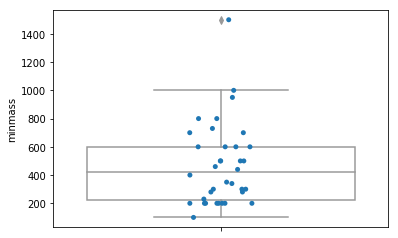

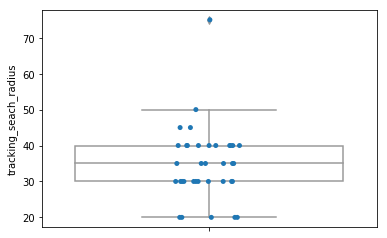

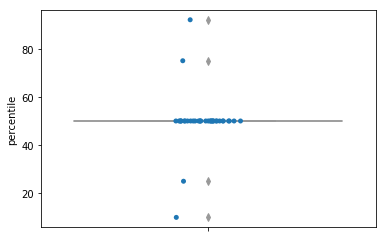

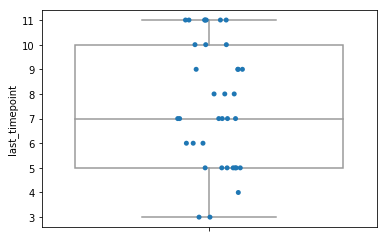

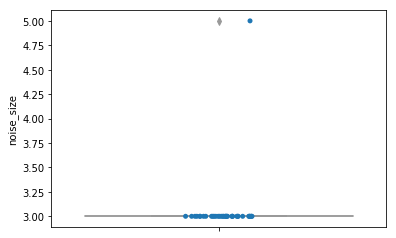

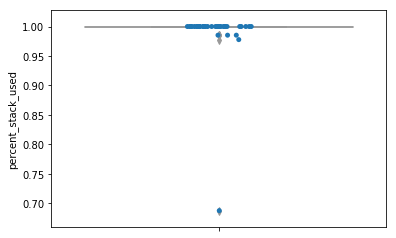

In [8]:
columns_to_plot = ['minmass', 'tracking_seach_radius', 'percentile', 'last_timepoint', 'noise_size','percent_stack_used']

axes = {}
figs = {}
for col in columns_to_plot:
    figs[col], axes[col] = plt.subplots()
    sns.stripplot(y=col, data=param_df,ax=axes[col], jitter=True)
    sns.boxplot(y=col, data=param_df, ax=axes[col], color='white')